In [1]:
!pip install git+https://github.com/jlcsilva/segmentation_models.pytorch

  Cloning https://github.com/jlcsilva/segmentation_models.pytorch to /tmp/pip-req-build-tkti9yig
  Running command git clone -q https://github.com/jlcsilva/segmentation_models.pytorch /tmp/pip-req-build-tkti9yig
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import json
import os
import shutil
import albumentations
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [3]:
PATH = "/app/_data/"
PATH_JSON1 = "/app/_data/json/1071_big.json"
PATH_JSON2 = "/app/_data/json/part_2_bb.json"
BATCH_SIZE = 64
SEED = 37
IMAGE_SIZE = 224
TRAIN_IMG_PATH = "/app/_data/train_images/"

In [4]:
df_bboxes = pd.read_csv("/app/_data/df_csv/df_boxes_colab.csv", index_col=[0])

In [5]:
with open(PATH_JSON1, "r") as read_file:
    data1 = json.load(read_file)
with open(PATH_JSON2, "r") as read_file:
    data2 = json.load(read_file)

In [6]:
data1.extend(data2)

In [7]:
len(data1)

1564

In [8]:
df = pd.DataFrame()
data = data1
for i in range(len(data)):
    img = data[i]["file_upload"].split(".")[0].split("_")[0] + ".jpg"
    df.loc[img, "image"] = img
    annot = data[i]["annotations"][0]["result"][0]["value"]
    df.loc[img, "x_min"] = annot["x"] / 100
    df.loc[img, "y_min"] = annot["y"] / 100
    df.loc[img, "x_max"] = (annot["x"] + annot["width"]) / 100
    df.loc[img, "y_max"] = (annot["y"] + annot["height"]) / 100

In [9]:
df

,image,x_min,y_min,x_max,y_max
fa529f125a27603e.jpg,fa529f125a27603e.jpg,0.000000,0.157766,0.973333,0.850299
fa888b5a2536b78a.jpg,fa888b5a2536b78a.jpg,0.094667,0.225631,0.862667,0.794411
fa900bfc9dc701aa.jpg,fa900bfc9dc701aa.jpg,0.137371,0.117845,0.706667,0.866267
fa952bc48883377a.jpg,fa952bc48883377a.jpg,0.081371,0.071937,0.934667,0.700599
fa958a3532aa99c9.jpg,fa958a3532aa99c9.jpg,0.186705,0.375333,0.641333,0.808383
...,...,...,...,...,...
fa95acc530b602de.jpg,fa95acc530b602de.jpg,0.218705,0.279524,0.673333,0.684631
fa95d1609bd90dc4.jpg,fa95d1609bd90dc4.jpg,0.098705,0.032042,0.918667,0.865009
fa097addd4f84260.jpg,fa097addd4f84260.jpg,0.028038,0.080080,0.910667,0.742000
fa108f246b1ceb1e.jpg,fa108f246b1ceb1e.jpg,0.193371,0.095889,0.781371,1.000000


In [10]:
class Dataset(BaseDataset):
    CLASSES = ["fire"]

    def __init__(
        self,
        df,
        images_dir,
        batch_size,
        img_size,
        n_chanels,
        cache_dir=None,
        shuffle=False,
        augment=True,
        normalize=False,
    ):
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.df = df.reset_index(drop=True)
        self.images_dir = images_dir
        self.img_size = img_size
        self.augment = augment
        self.normalize = normalize
        self.cache_dir = cache_dir
        self.n_chanels = n_chanels
        if self.shuffle:
            self.df = self.df.sample(frac=1, random_state=42).reset_index(drop=True)
        if self.cache_dir is not None:
            os.makedirs(self.cache_dir, exist_ok=True)

    def get_image(self, img_name):
        try:
            img = np.load(self.cache_dir + img_name)
        except:
            img = cv2.imread("/app/_data/train_images/" + img_name)
            img = cv2.resize(
                img, [self.img_size, self.img_size], interpolation=cv2.INTER_LINEAR
            )
            if self.normalize:
                img = (img - img.min()) / (img.max() - img.min())
            if self.n_chanels > 3:
                chanels = np.random.randint(0, 3, self.n_chanels - 3)
                img = np.concatenate(
                    [img, np.stack([img[:, :, i] for i in chanels], axis=-1)], axis=-1
                )
            if self.cache_dir is not None:
                np.save(self.cache_dir + img_name[:-4], img)
        return img

    def __getitem__(self, ix):
        """
        Get single item by absolute index
        """

        # img
        img_name = self.df.loc[ix, "image"]
        img = self.get_image(img_name)

        # mask
        mask = np.zeros([self.img_size, self.img_size], dtype="uint8")
        x_min = int(self.df.loc[ix, "x_min"] * self.img_size)
        y_min = int(self.df.loc[ix, "y_min"] * self.img_size)
        x_max = int(self.df.loc[ix, "x_max"] * self.img_size) + 1
        y_max = int(self.df.loc[ix, "y_max"] * self.img_size) + 1
        mask[y_min:y_max, x_min:x_max] = 1

        # augment
        if self.augment:
            img, mask = self._augment_image(img, mask)
        return img.transpose(2, 0, 1).astype('float32'), np.expand_dims(mask, 0)

    def _augment_image(self, image, mask):
        transform = albumentations.Compose(
            [
                albumentations.OneOf(
                    [
                        albumentations.HorizontalFlip(),
                        albumentations.VerticalFlip(),
                        albumentations.augmentations.geometric.rotate.RandomRotate90(),
                    ],
                    p=0.1,
                ),
            ]
        )
        transformed = transform(image=image, mask=mask)
        transformed_image = transformed["image"]
        transformed_mask = transformed["mask"]
        return transformed_image, transformed_mask

    def __len__(self):
        return self.df.shape[0]

In [11]:
train, val = train_test_split(df, train_size=0.8, random_state=42)

In [12]:
dataset = Dataset(
    df=df,
    images_dir="/app/_data/train_images/",
    cache_dir="/app/_data/cache_segm/",
    batch_size=16,
    img_size=384,
    n_chanels=3,
    shuffle=True,
    augment=True,
    normalize=True,
)

In [13]:
image, mask = dataset[4]

In [14]:
mask.shape

(1, 384, 384)

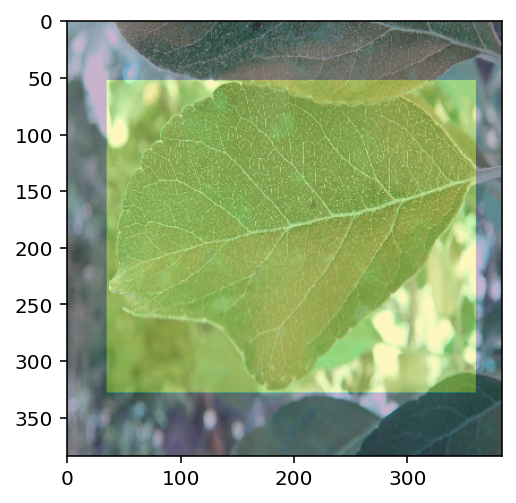

In [15]:
plt.imshow(image.transpose(1, 2, 0))
plt.imshow(mask[0], alpha=0.3)

In [16]:
import segmentation_models_pytorch as smp
import torch

In [17]:
#     "efficientnet-b4": {
#         "encoder": EfficientNetEncoder,
#         "pretrained_settings": _get_pretrained_settings("efficientnet-b4"),
#         "params": {
#             "out_channels": (3, 48, 32, 56, 160, 448),
#             "stage_idxs": (6, 10, 22, 32),
#             "model_name": "efficientnet-b4",
#         },

In [18]:
ENCODER = "efficientnet-b4"
ENCODER_WEIGHTS = "imagenet"
CLASSES = ["fire"]
ACTIVATION = (
    "sigmoid"  # could be None for logits or 'softmax2d' for multiclass segmentation
)
DEVICE = "cuda"

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)

In [19]:
shutil.rmtree('/app/_data/cache_segm/')

In [20]:
train_dataset = Dataset(
    df=train,
    images_dir="/app/_data/train_images/",
    cache_dir="/app/_data/cache_segm/",
    batch_size=16,
    img_size=384,
    n_chanels=3,
    shuffle=True,
    augment=True,
    normalize=True,
)
valid_dataset = Dataset(
    df=val,
    images_dir="/app/_data/train_images/",
    cache_dir="/app/_data/cache_segm/",
    batch_size=16,
    img_size=384,
    n_chanels=3,
    shuffle=False,
    augment=False,
    normalize=True,
)

In [21]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=4)

In [22]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam(
    [
        dict(params=model.parameters(), lr=0.001),
    ]
)

In [23]:
# create epoch runners
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [24]:
# train model for 40 epochs

max_score = 0

for i in range(0, 10):

    print("\nEpoch: {}".format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs["iou_score"]:
        max_score = valid_logs["iou_score"]
        print("Model saved!")

    if i == 25:
        optimizer.param_groups[0]["lr"] = 1e-4
        print("Decrease decoder learning rate to 1e-5!")


Epoch: 0
valid: 100%|██████████| 76/76 [00:10<00:00,  6.95it/s, dice_loss - 0.04608, iou_score - 0.9139]
Model saved!

Epoch: 1
valid: 100%|██████████| 76/76 [00:10<00:00,  6.93it/s, dice_loss - 0.02862, iou_score - 0.9455]
Model saved!

Epoch: 2
valid: 100%|██████████| 76/76 [00:10<00:00,  6.95it/s, dice_loss - 0.02734, iou_score - 0.948] 
Model saved!

Epoch: 3
valid: 100%|██████████| 76/76 [00:11<00:00,  6.88it/s, dice_loss - 0.02501, iou_score - 0.9523]
Model saved!

Epoch: 4
valid: 100%|██████████| 76/76 [00:10<00:00,  6.94it/s, dice_loss - 0.01959, iou_score - 0.9625]
Model saved!

Epoch: 5
valid: 100%|██████████| 76/76 [00:10<00:00,  6.92it/s, dice_loss - 0.01634, iou_score - 0.9686]
Model saved!

Epoch: 6
valid: 100%|██████████| 76/76 [00:10<00:00,  6.94it/s, dice_loss - 0.01799, iou_score - 0.9653]

Epoch: 7
valid: 100%|██████████| 76/76 [00:11<00:00,  6.81it/s, dice_loss - 0.01787, iou_score - 0.9656]

Epoch: 8
valid: 100%|██████████| 76/76 [00:11<00:00,  6.74it/s, dice_loss

In [25]:
a,b = next(iter(train_loader))

In [55]:
torch.cuda.empty_cache()

In [26]:
c = model(a.cuda()).cpu()

In [33]:
cc = c[0].detach().numpy()
cc.shape

(1, 384, 384)

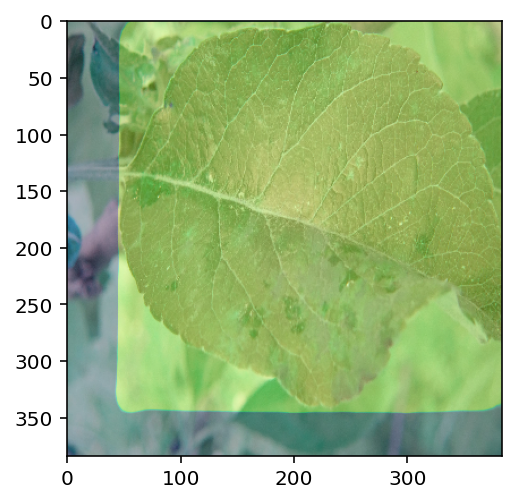

In [36]:
plt.imshow(a[0].detach().numpy().transpose(1, 2, 0))
plt.imshow(cc[0], alpha = 0.3)